<a href="https://colab.research.google.com/github/syedsajidhussain/ideal-computing-machine/blob/main/train_face_kps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision

import numbers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from utils_pytorch import TorchModel, TrainConfig
from torchvision.transforms import ToTensor


data_folder = './data/data_kps'
train_file = os.path.join(data_folder, 'training.csv')
test_file = os.path.join(data_folder, 'test.csv')
idlookup_file = os.path.join(data_folder, 'IdLookupTable.csv')
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
idlookup_data = pd.read_csv(idlookup_file)

def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

train_data.isnull().sum()

clean_train_data = train_data.dropna()
print("clean_train_data shape:", np.shape(clean_train_data))

unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape:", np.shape(unclean_train_data))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)


In [ ]:
# %%time

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features


Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)


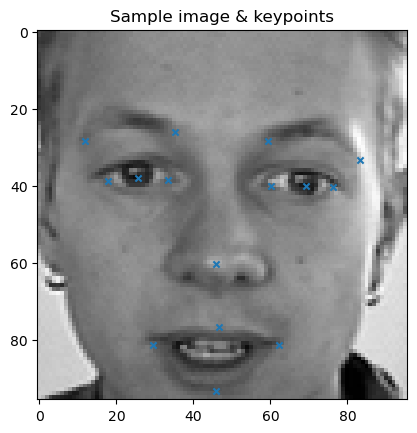

Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)


In [ ]:
clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images:", np.shape(clean_train_images))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints:", np.shape(clean_train_keypoints))
test_images = load_images(test_data)
print("Shape of test_images:", np.shape(test_images))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[19], clean_train_keypoints[19], axis, "Sample image & keypoints")
plt.show()

unclean_train_images = load_images(unclean_train_data)
print("Shape of unclean_train_images:", np.shape(unclean_train_images))
unclean_train_keypoints = load_keypoints(unclean_train_data)
print("Shape of unclean_train_keypoints:", np.shape(unclean_train_keypoints))
train_images = np.concatenate((train_images, unclean_train_images))
train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

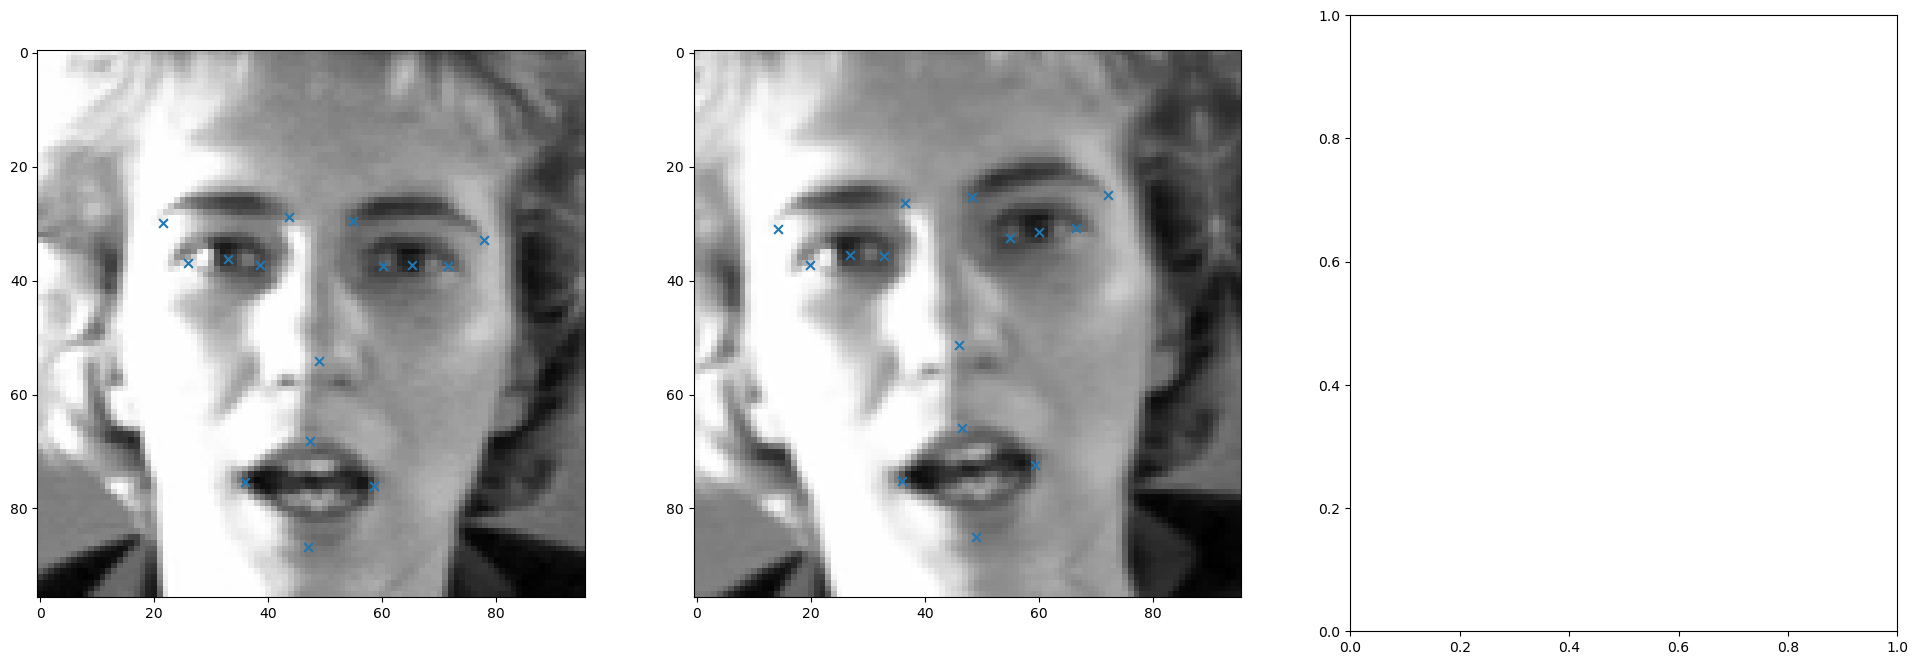

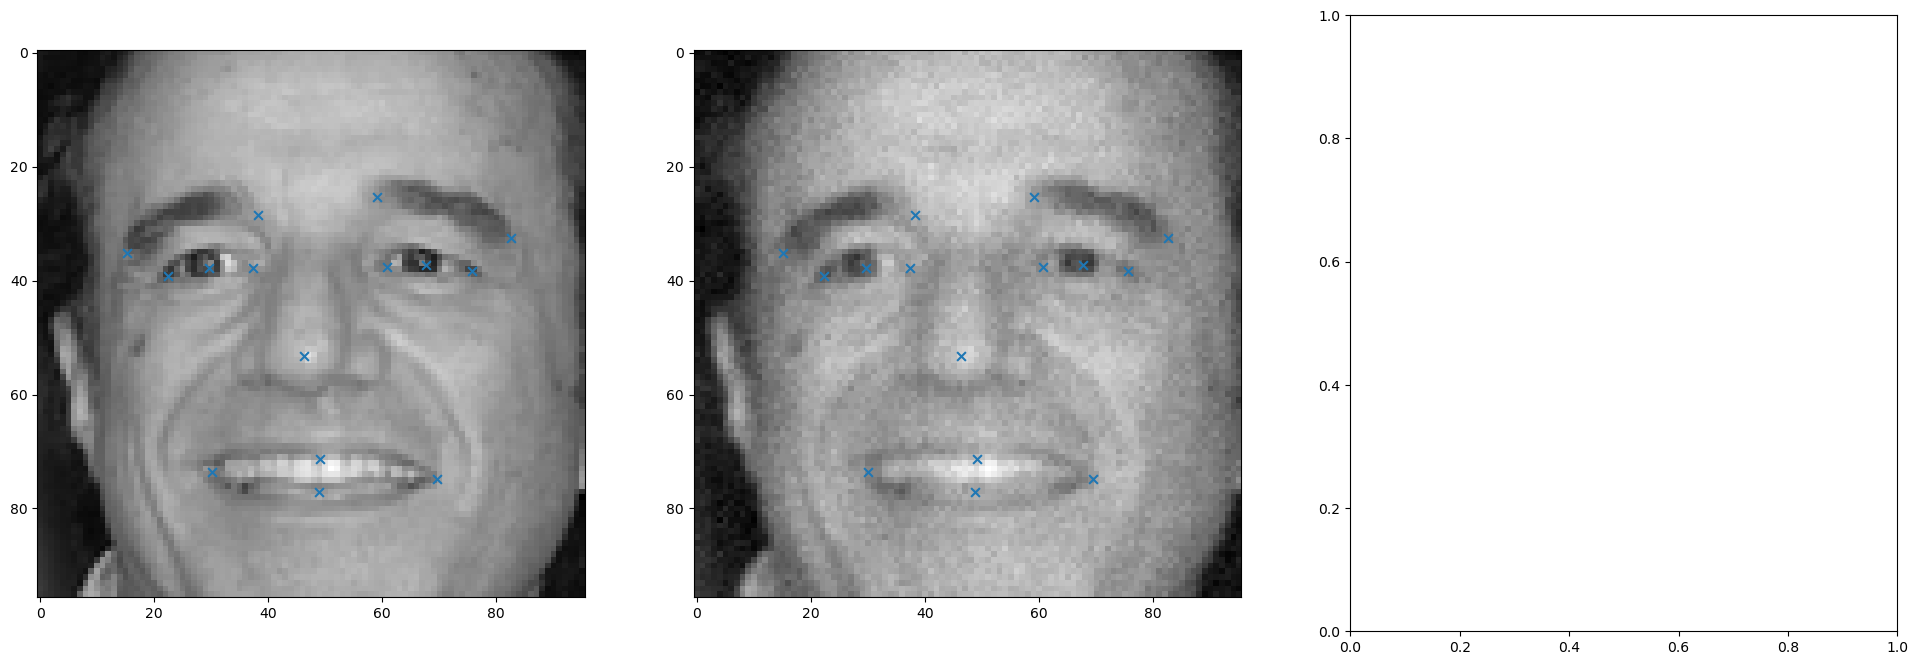

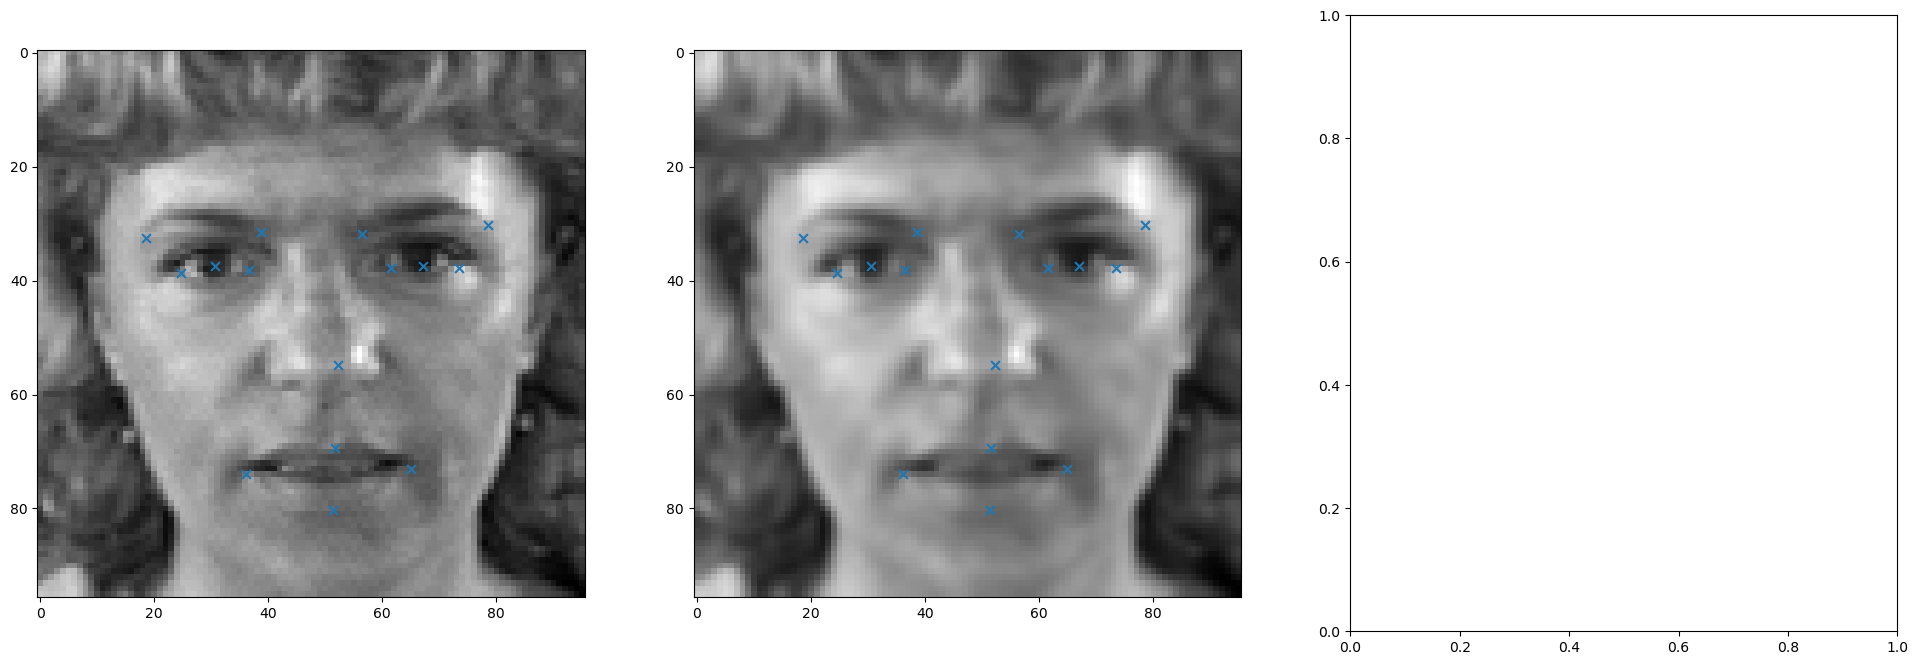

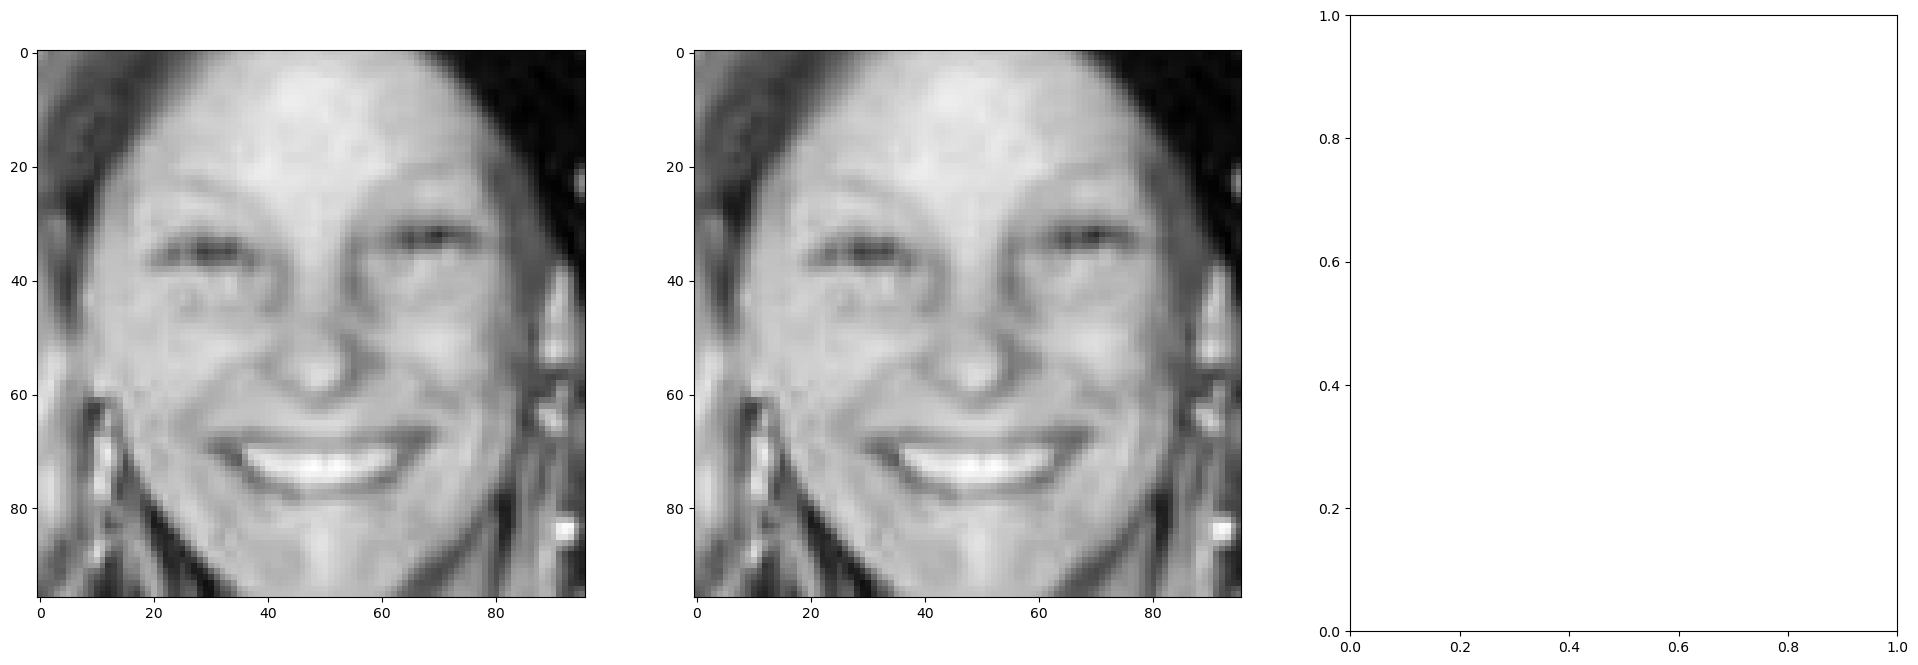

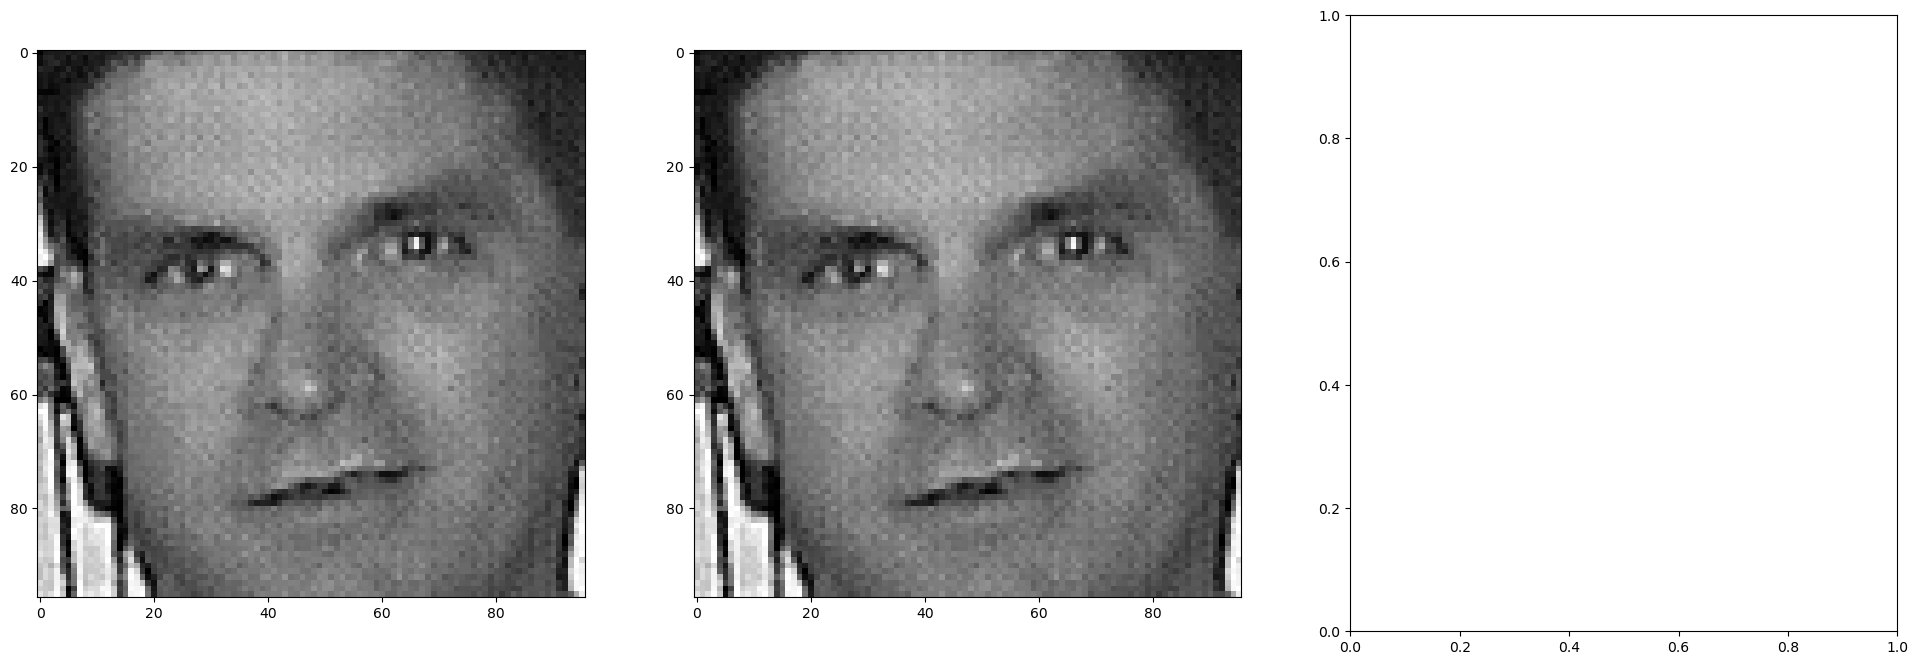

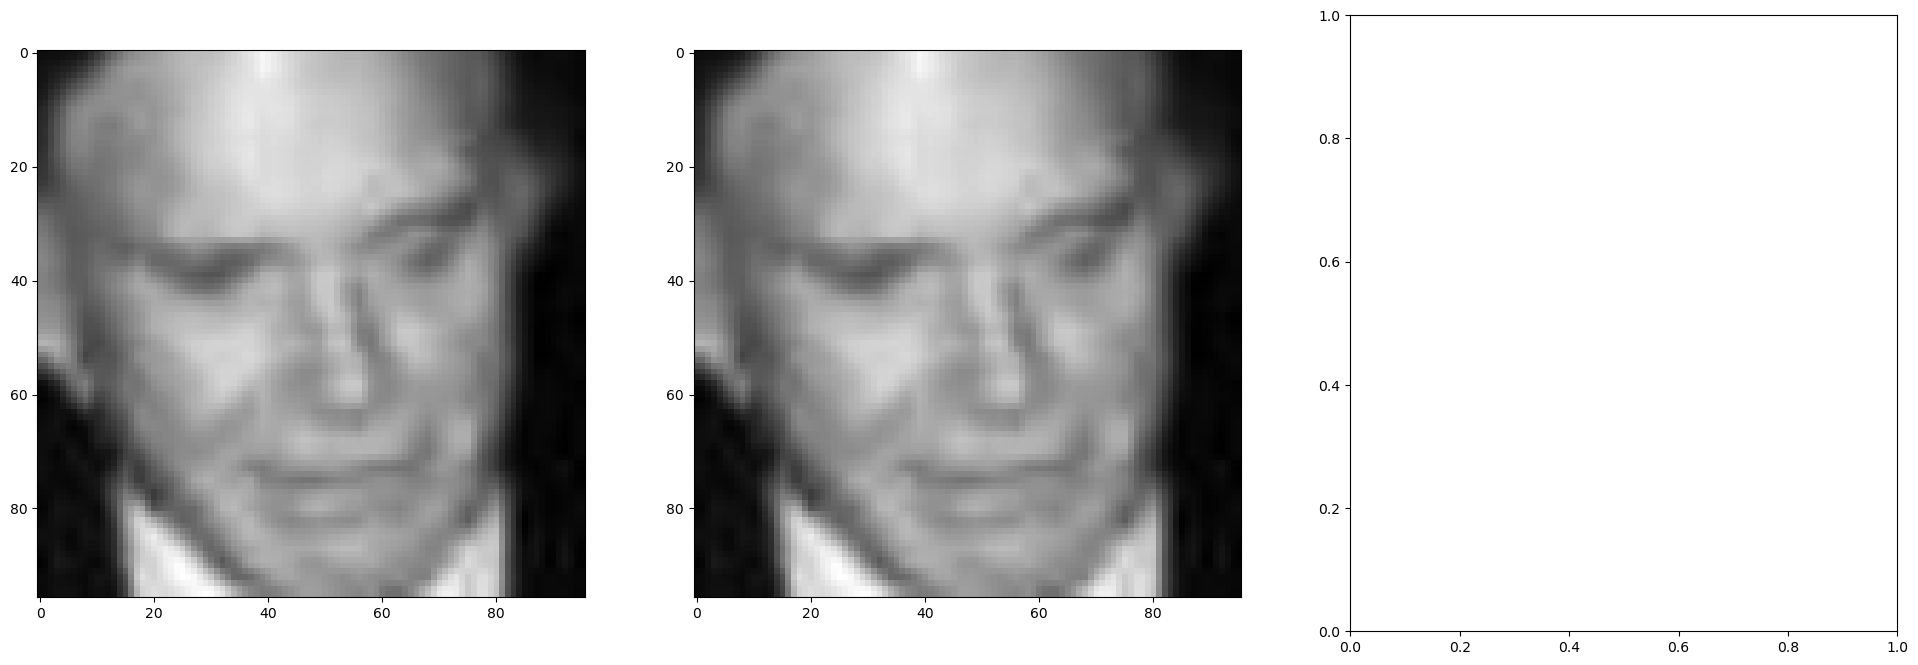

In [ ]:
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, images, keypoints=None, processor=None, **kwargs):
        self.images = images.astype('float32')
        if keypoints is None:
            keypoints = [None] * len(self.images)
        self.keypoints = keypoints
        self.processor = processor
        self.kwargs = kwargs
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        kps = self.keypoints[idx]
        if self.processor is not None:
            img, kps = self.processor(img, kps, **self.kwargs)
        
        img = ToTensor()(img)
        if kps is not None:
            kps = torch.as_tensor(kps, dtype=torch.float32)
        
        return img, kps
    
    def display(self, indices=None, results=None):
        if indices is None:
            indices = range(len(self))
        elif isinstance(indices, numbers.Number):
            indices = np.random.choice(len(self), indices)
        
        for idx in indices:
            image, keypoint = self.images[idx], self.keypoints[idx]
            img, kps = self[idx]
            
            fig, axes = plt.subplots(1, 3, figsize=(24, 8))
            axes[0].imshow(image, cmap='gray')
            if keypoint is not None:
                axes[0].scatter(keypoint[0::2], keypoint[1::2], marker='x', s=40)
            axes[1].imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
            if kps is not None:
                axes[1].scatter(kps.numpy()[::2], kps.numpy()[1::2], marker='x', s=40)
            
            if results is not None:
                res = results[i]
                
            plt.show()


def train_processor(img, kps, **kwargs):
    tf = A.Compose([
        A.ShiftScaleRotate(rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(var_limit=(1e-5, 1e-3), p=0.5)
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
    
    kps = np.array(tuple(zip(kps[::2], kps[1::2])))
    transformed = tf(image=img, keypoints=kps)
    img = transformed['image']
    kps = np.array(transformed['keypoints']).flatten(order='C')
    
    return img, kps

def val_processor(img, kps, **kwargs):
    return img, kps

train_dataset = FaceDataset(clean_train_images, clean_train_keypoints, processor=train_processor)
val_dataset = FaceDataset(clean_train_images, clean_train_keypoints, processor=None)
test_dataset = FaceDataset(test_images, None, processor=None)
train_dataset.display(3)
test_dataset.display(3)

In [ ]:

class FaceModel(TorchModel):
    def build_model(self, backbone='mobilenet_v2', n_kps=30):
        model = getattr(torchvision.models, backbone)(pretrained=True, progress=False)
        model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        model.classifier[-1] = torch.nn.Linear(in_features=model.classifier[-1].in_features, out_features=n_kps, bias=True)
        
        return model
    
    def get_criterion(self, config):
        """ Set up criterions. """
        return {'loss': torch.nn.MSELoss(), 'mae': torch.nn.L1Loss()}

model = FaceModel(model_name='face_kps', model_dir='./test', backbone='mobilenet_v2', n_kps=30)


In [ ]:
train_config = TrainConfig(
    GPU_IDS = [1],
    BATCH_SIZE = 32,
    TRAINABLE_LAYERS = ".*",
    SAVE_STATE = True,
    SAVE_FREQUENCY = 0,
    EVAL_FREQUENCY = 1,
    LOSS_WEIGHTS = None,
    CLASS_WEIGHTS = None,
    
    OPTIMIZER = ('SGD', {'lr': 0.001, 'momentum': 0.9}),
    GRADIENT_CLIPNORM = 0.0,
    GRADIENT_CLIPVALUE = 0.0,
    
    ## Callbacks
    LR_SCHEDULER = ('MultiStepLR', {'milestones': [300, 800], 'gamma': 0.5}),
    EARLY_STOPPING = ('loss/val', {'patience': 50, 'mode': 'min'}),
    REDUCE_LR_ON_PLATEAU = ('loss/val', {'mode': 'min', 'factor': 0.1, 
                            'patience': 50, 'verbose': False, 'threshold': 1e-4}),
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_config.BATCH_SIZE, shuffle=True,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_config.BATCH_SIZE, shuffle=False
)

model.train(train_loader, val_loader, epochs=100, config=train_config, 
            trainable_layers=".*", verbose=1)

Create logdir: ./test/face_kps_20211120T181310
Starting at epoch 0. lr=0.001
Checkpoint Path: ./test/face_kps_20211120T181310/face_kps_{epoch:04d}.pt


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.26it/s, loss=36.7486, mae=4.4018]

Epoch 2, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.25it/s, loss=40.2002, mae=4.6598]

Epoch 3, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.58it/s, loss=37.6432, mae=4.4395]

Epoch 4, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s, loss=27.7520, mae=3.8128]

Epoch 5, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.42it/s, loss=35.2110, mae=4.3199]

Epoch 6, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.52it/s, loss=32.3410, mae=4.1272]

Epoch 7, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.08it/s, loss=30.3587, mae=4.0590]

Epoch 8, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.64it/s, loss=32.2056, mae=4.1307]

Epoch 9, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.67it/s, loss=33.3105, mae=4.2842]

Epoch 10, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s, loss=37.4994, mae=4.4240]

Epoch 11, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.81it/s, loss=35.8251, mae=4.4420]

Epoch 12, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s, loss=25.7613, mae=3.6937]

Epoch 13, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 13.97it/s, loss=21.8738, mae=3.4737]

Epoch 14, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s, loss=18.6355, mae=3.3045]

Epoch 15, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.82it/s, loss=18.5031, mae=3.1547]

Epoch 16, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.19it/s, loss=18.8094, mae=3.1915]

Epoch 17, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.68it/s, loss=13.6703, mae=2.7727]

Epoch 18, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s, loss=12.0682, mae=2.6745]

Epoch 19, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s, loss=13.2280, mae=2.8288]

Epoch 20, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.22it/s, loss=17.8912, mae=3.1858]

Epoch 21, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.67it/s, loss=12.1216, mae=2.6581]

Epoch 22, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.99it/s, loss=12.3113, mae=2.6502]

Epoch 23, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s, loss=11.4228, mae=2.5058]

Epoch 24, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.33it/s, loss=12.8386, mae=2.6415]

Epoch 25, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.71it/s, loss=12.1876, mae=2.6911]

Epoch 26, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.54it/s, loss=10.7369, mae=2.4844]

Epoch 27, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.25it/s, loss=9.3688, mae=2.3176] 

Epoch 28, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.35it/s, loss=10.0500, mae=2.3800]

Epoch 29, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.63it/s, loss=10.5848, mae=2.3716]

Epoch 30, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s, loss=9.5502, mae=2.3376] 

Epoch 31, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.89it/s, loss=8.2774, mae=2.1339]

Epoch 32, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.63it/s, loss=9.5368, mae=2.3931]

Epoch 33, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.55it/s, loss=8.4721, mae=2.1808]

Epoch 34, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.65it/s, loss=7.1970, mae=1.9689]

Epoch 35, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.55it/s, loss=7.7483, mae=2.0958]

Epoch 36, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.19it/s, loss=8.4894, mae=2.1393]

Epoch 37, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.94it/s, loss=6.4522, mae=1.9163]

Epoch 38, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.84it/s, loss=6.9436, mae=2.0192]

Epoch 39, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.58it/s, loss=6.8642, mae=1.9599]

Epoch 40, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s, loss=6.5126, mae=1.9599]

Epoch 41, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.88it/s, loss=5.7666, mae=1.7998]

Epoch 42, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 13.24it/s, loss=7.7292, mae=2.0249]

Epoch 43, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s, loss=7.3122, mae=2.0290]

Epoch 44, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.80it/s, loss=7.1553, mae=2.0583]

Epoch 45, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.85it/s, loss=6.5777, mae=1.9149]

Epoch 46, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s, loss=6.5176, mae=1.9301]

Epoch 47, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.41it/s, loss=6.7503, mae=1.9746]

Epoch 48, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.61it/s, loss=6.2369, mae=1.8755]

Epoch 49, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.57it/s, loss=6.0448, mae=1.8169]

Epoch 50, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s, loss=7.3944, mae=2.0445]

Epoch 51, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.95it/s, loss=6.8482, mae=1.9918]

Epoch 52, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.72it/s, loss=6.9137, mae=2.0333]

Epoch 53, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s, loss=6.8716, mae=1.9413]

Epoch 54, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s, loss=7.0790, mae=1.9837]

Epoch 55, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.29it/s, loss=5.3768, mae=1.7236]

Epoch 56, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.04it/s, loss=5.8246, mae=1.8091]

Epoch 57, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s, loss=5.9044, mae=1.8690]

Epoch 58, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s, loss=6.0360, mae=1.8505]

Epoch 59, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.69it/s, loss=6.1369, mae=1.9254]

Epoch 60, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s, loss=5.2939, mae=1.7215]

Epoch 61, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.79it/s, loss=6.1536, mae=1.8384]

Epoch 62, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.73it/s, loss=6.9393, mae=1.9864]

Epoch 63, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.97it/s, loss=5.5414, mae=1.7719]

Epoch 64, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s, loss=6.6616, mae=1.9664]

Epoch 65, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.73it/s, loss=6.5409, mae=1.9487]

Epoch 66, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s, loss=6.9867, mae=2.0324]

Epoch 67, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.89it/s, loss=5.5750, mae=1.7298]

Epoch 68, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.44it/s, loss=7.0400, mae=2.0511]

Epoch 69, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s, loss=4.9107, mae=1.6833]

Epoch 70, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.65it/s, loss=7.0817, mae=1.9679]

Epoch 71, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s, loss=5.4909, mae=1.7611]

Epoch 72, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.60it/s, loss=5.6578, mae=1.8133]

Epoch 73, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s, loss=5.8182, mae=1.7887]

Epoch 74, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.17it/s, loss=4.9626, mae=1.6987]

Epoch 75, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.85it/s, loss=5.4034, mae=1.7840]

Epoch 76, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.27it/s, loss=5.4268, mae=1.7358]

Epoch 77, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.03it/s, loss=5.8772, mae=1.7959]

Epoch 78, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 13.74it/s, loss=5.5733, mae=1.7798]

Epoch 79, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.94it/s, loss=5.5549, mae=1.7973]

Epoch 80, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s, loss=5.1604, mae=1.6911]

Epoch 81, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.39it/s, loss=5.6063, mae=1.7933]

Epoch 82, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.61it/s, loss=4.4521, mae=1.5633]

Epoch 83, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.21it/s, loss=5.2290, mae=1.7452]

Epoch 84, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.11it/s, loss=4.6330, mae=1.5988]

Epoch 85, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.99it/s, loss=5.5906, mae=1.7705]

Epoch 86, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.61it/s, loss=5.2400, mae=1.7463]

Epoch 87, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.23it/s, loss=4.6688, mae=1.6122]

Epoch 88, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.75it/s, loss=5.7954, mae=1.8095]

Epoch 89, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.00it/s, loss=5.7441, mae=1.7608]

Epoch 90, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.95it/s, loss=4.4615, mae=1.5954]

Epoch 91, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.29it/s, loss=5.0453, mae=1.7067]

Epoch 92, lr=0.001000


  3%|▎         | 2/67 [00:00<00:03, 16.38it/s, loss=4.5920, mae=1.6245]

Epoch 93, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.97it/s, loss=6.1201, mae=1.8324]

Epoch 94, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 14.17it/s, loss=5.4174, mae=1.7353]

Epoch 95, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 13.96it/s, loss=4.8931, mae=1.6167]

Epoch 96, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.60it/s, loss=5.5257, mae=1.7781]

Epoch 97, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s, loss=5.2386, mae=1.7173]

Epoch 98, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 15.88it/s, loss=4.7989, mae=1.6485]

Epoch 99, lr=0.001000


  3%|▎         | 2/67 [00:00<00:04, 16.17it/s, loss=4.8970, mae=1.6592]

Epoch 100, lr=0.001000


100%|██████████| 67/67 [00:00<00:00, 181.67it/s, val_loss=3.4396, val_mae=1.3716]


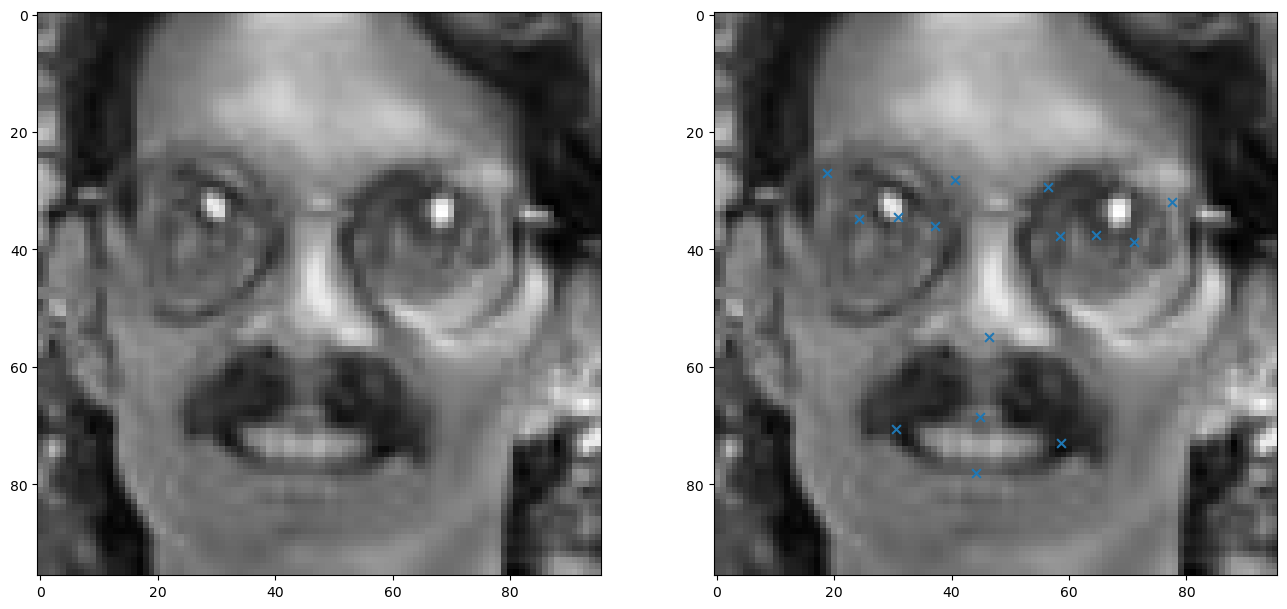

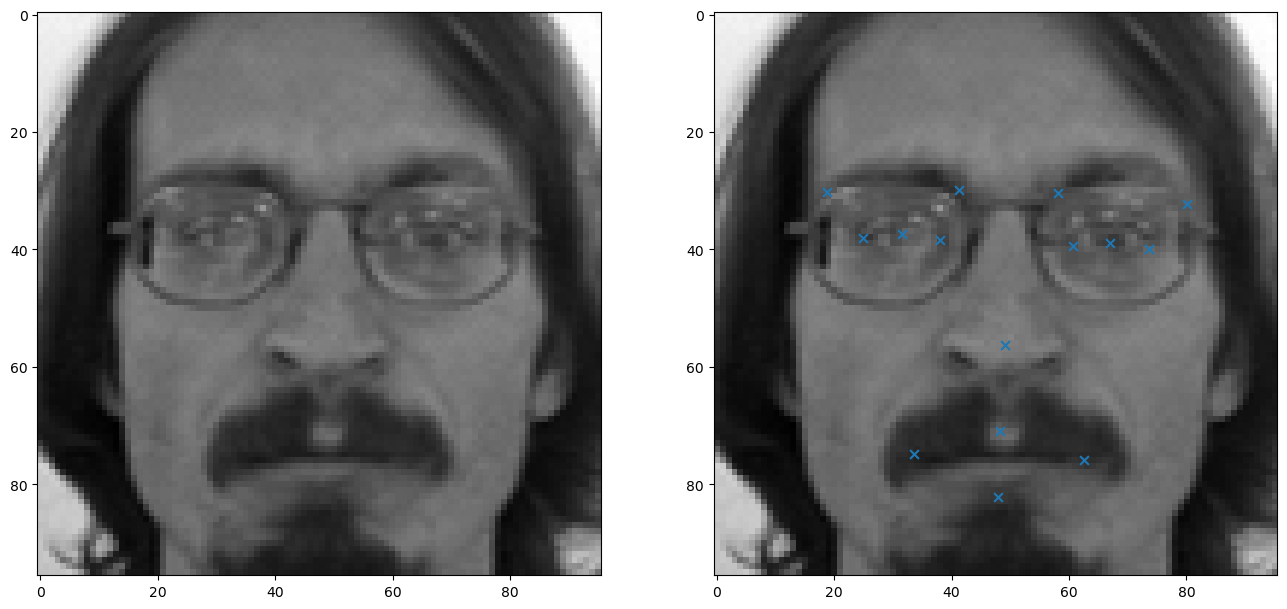

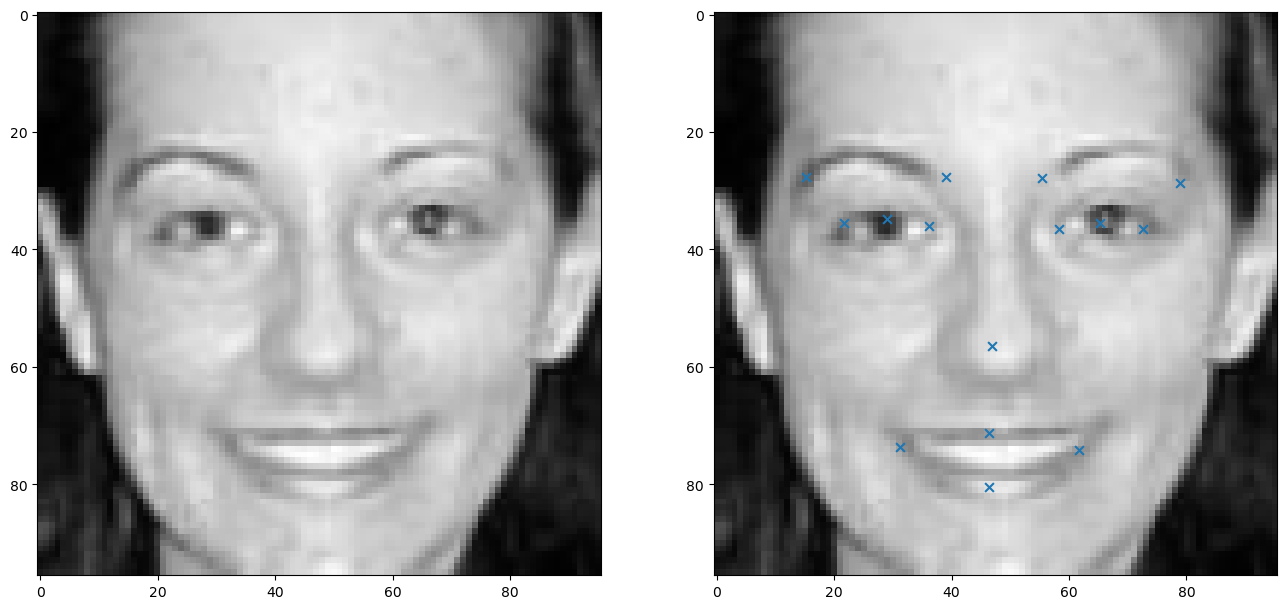

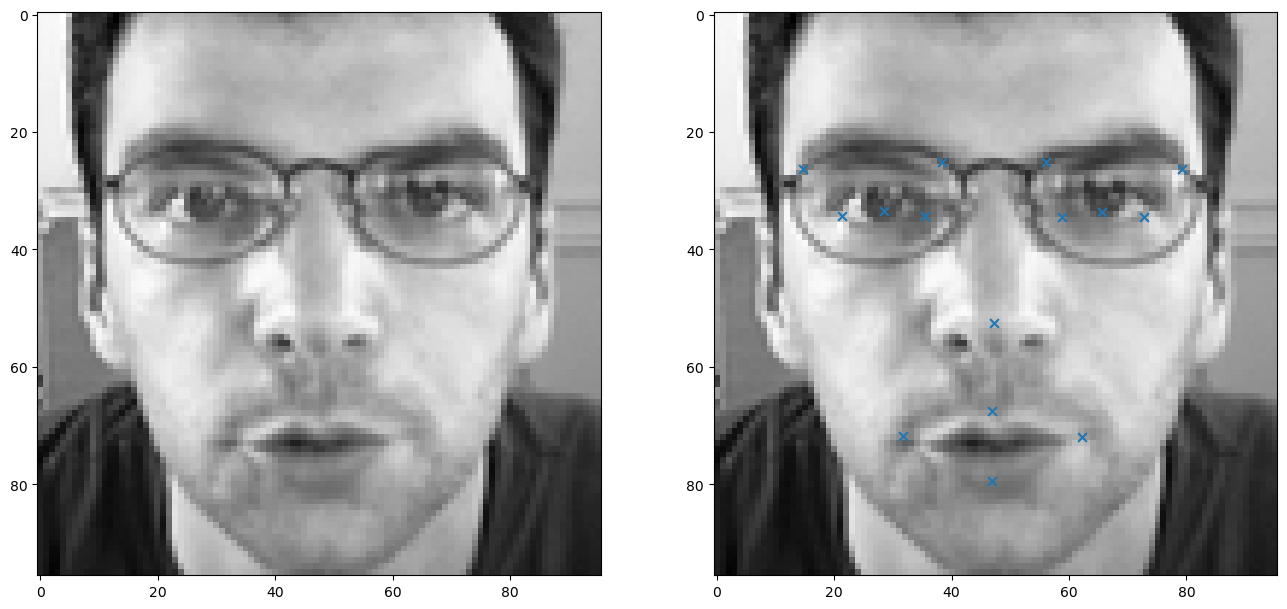

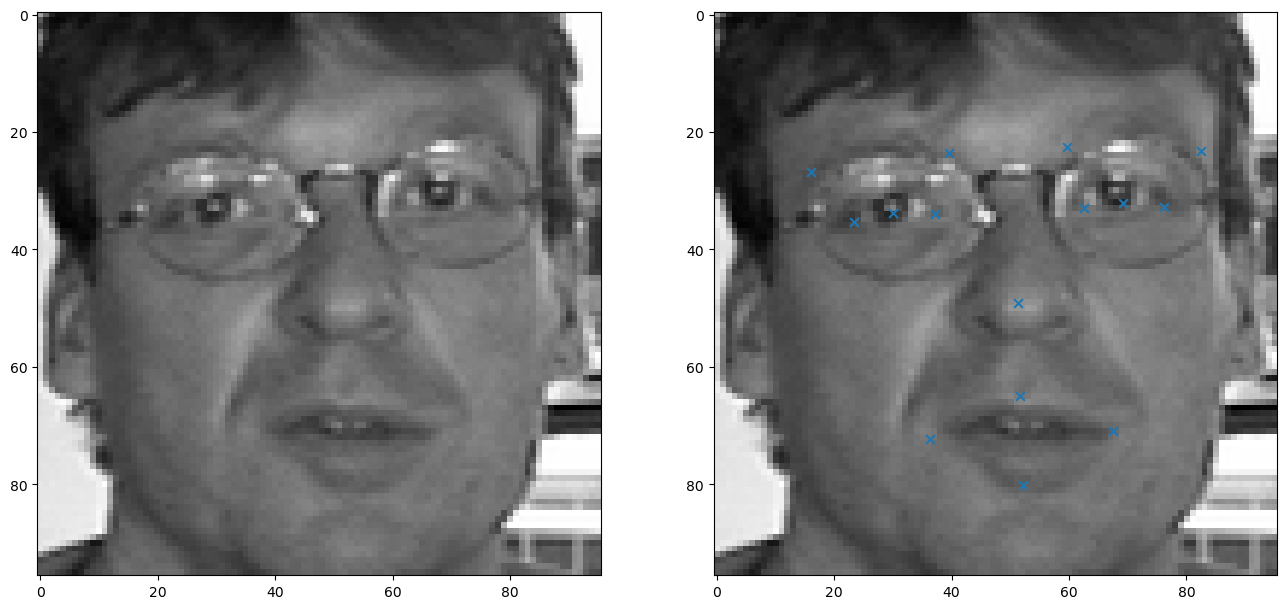

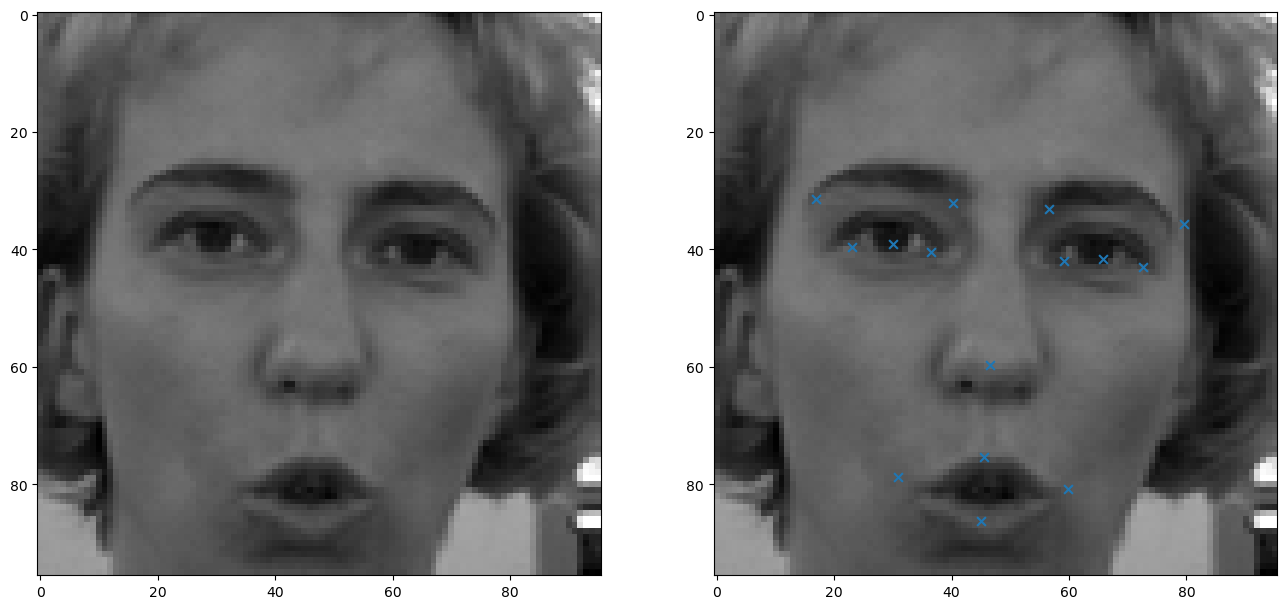

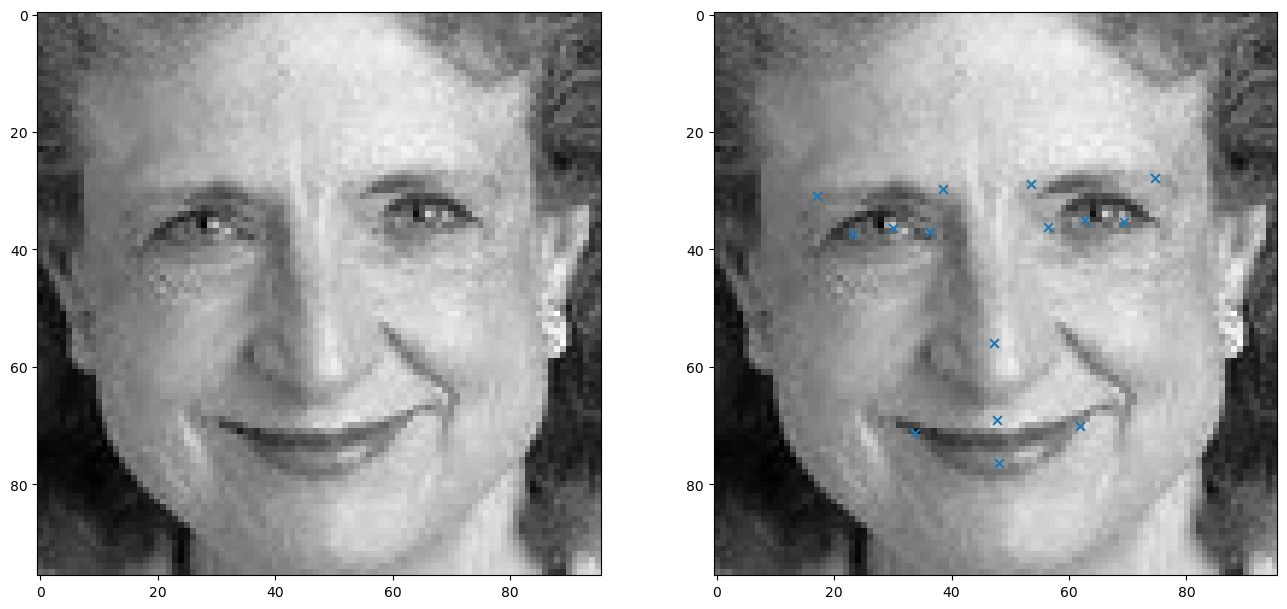

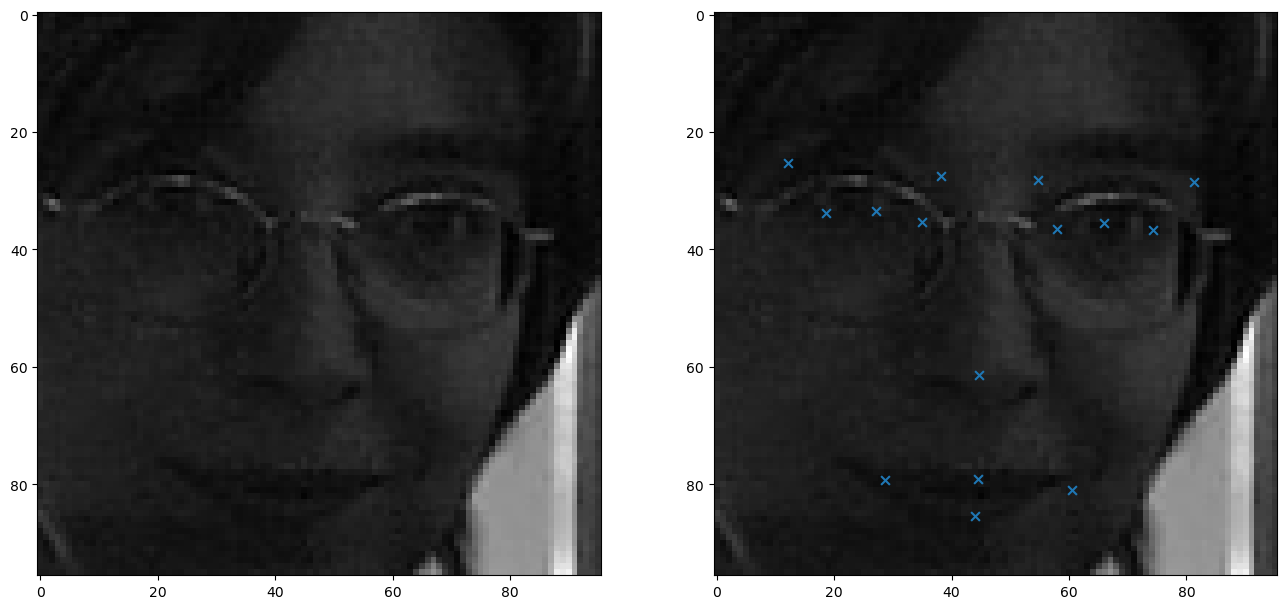

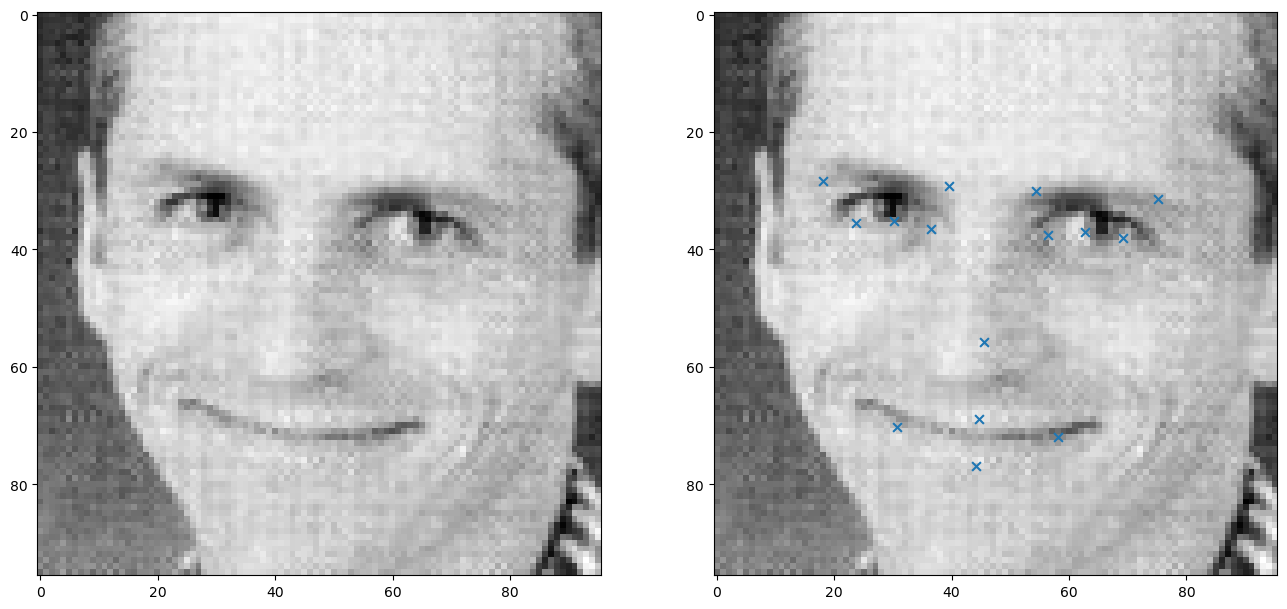

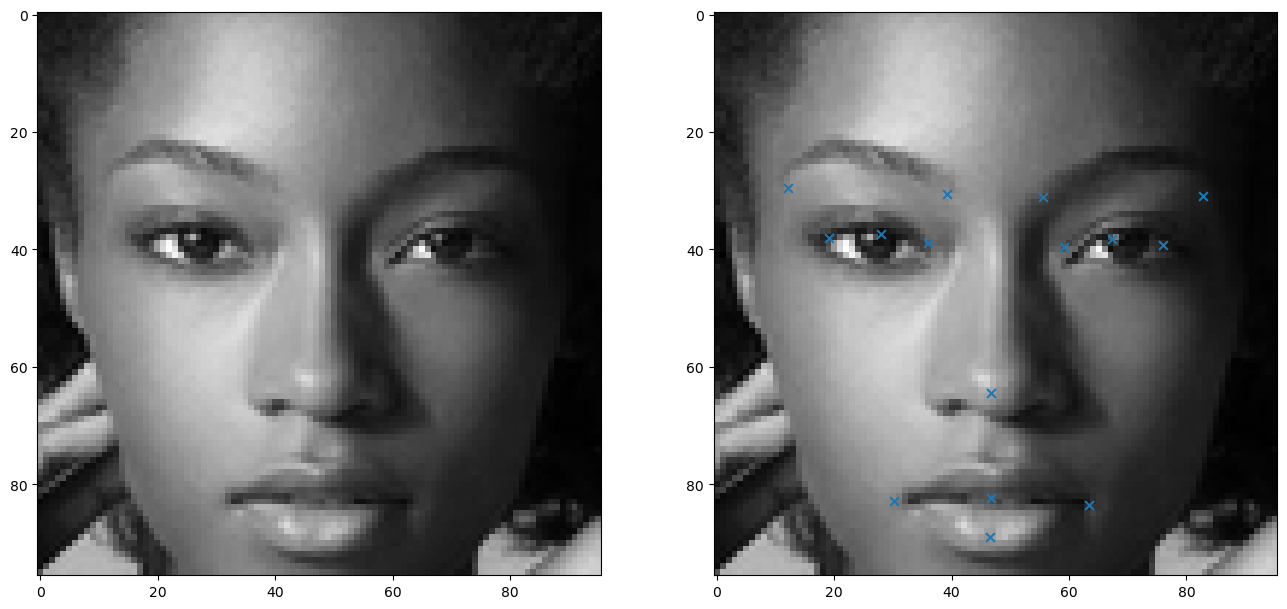

In [ ]:
# def predict_on_loader(self, dataloader):
#     # set model to eval mode
#     self.model.eval()

#     res = []
#     for batch_data in dataloader:
#         batch_data = to_device(batch_data, self.device)
#         with torch.no_grad():
#             outputs = self.model(batch_data)
#         res.append(outputs)
#     ## res is a list of list of tensors, nrow = len(dataloader), ncol = no. of outputs
#     return [torch.cat(list(output), dim=0) for output in zip(*res)]

class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, processor=None, **kwargs):
        self.images = images.astype('float32')
        self.processor = processor
        self.kwargs = kwargs
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.processor is not None:
            img = self.processor(img, **self.kwargs)

        return ToTensor()(img)
    
    def display(self, indices=None, results=None):
        if indices is None:
            indices = range(len(self))
        elif isinstance(indices, numbers.Number):
            indices = np.random.choice(len(self), indices)
        
        for idx in indices:
            image = self.images[idx]
            img = self[idx]
            
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            axes[0].imshow(image, cmap='gray')
            axes[1].imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
            if results is not None:
                res = results[idx]
                axes[1].scatter(res.numpy()[::2], res.numpy()[1::2], marker='x', s=40)
            plt.show()

test_dataset = ImagesDataset(train_images, processor=None)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_config.BATCH_SIZE, shuffle=False,
)

res = model.predict_on_loader(test_loader).to('cpu')
test_dataset.display(10, res)

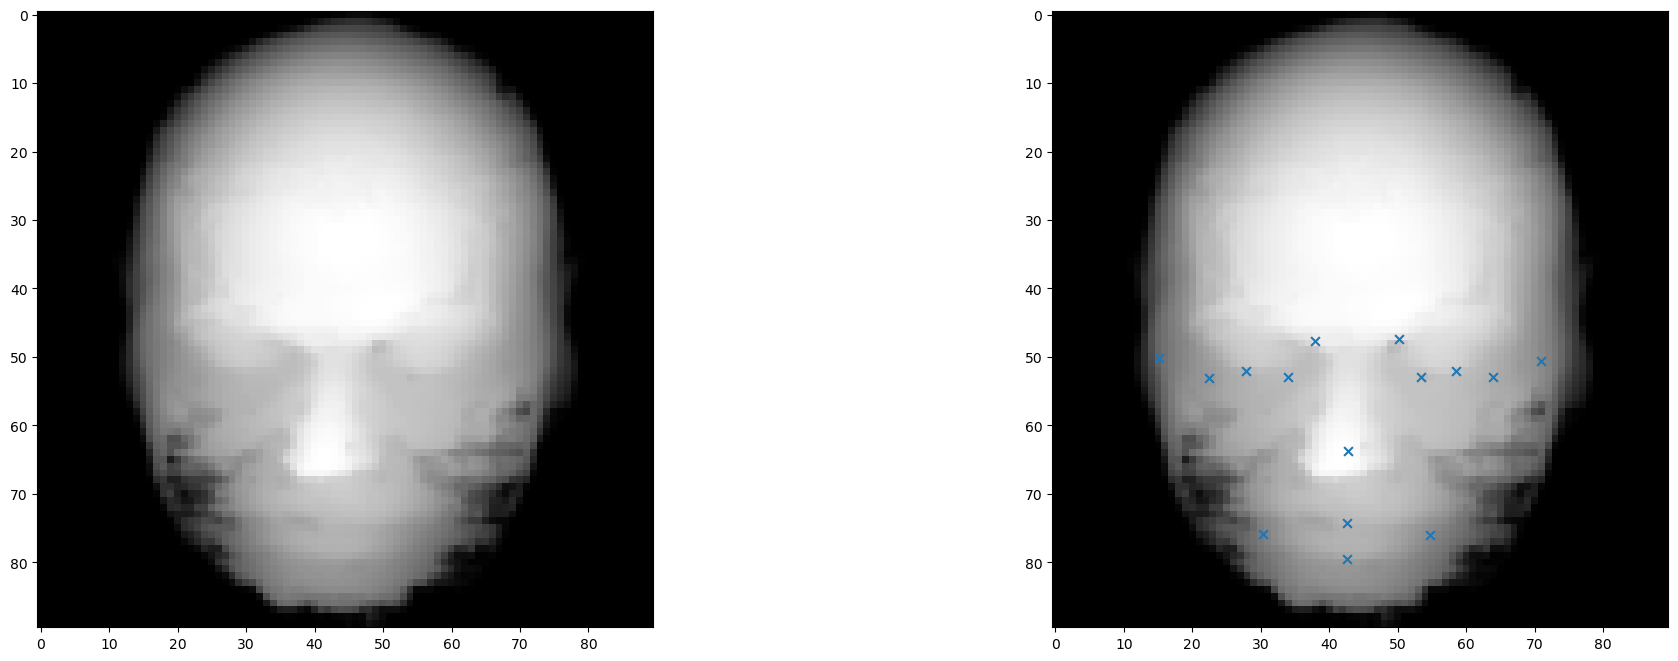

In [ ]:
from PIL import Image
from utils_image import *
img = np.array(Image.open("aaa.png").convert('L')).astype('float32')
face = img[0:650, 200:550]
face = resize(img[0:650, 200:580], (90, 90))

model.model.eval()
r = model.model(ToTensor()(face).to(model.device)[None]).detach().cpu()[0]
r = torch.as_tensor(clean_train_keypoints)[2]*0.9
r[1::2] = r[1::2]*0.7+30

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes[0].imshow(face, cmap='gray')
axes[1].imshow(face, cmap='gray')
axes[1].scatter(r.numpy()[::2], r.numpy()[1::2], marker='x', s=40)
plt.show()

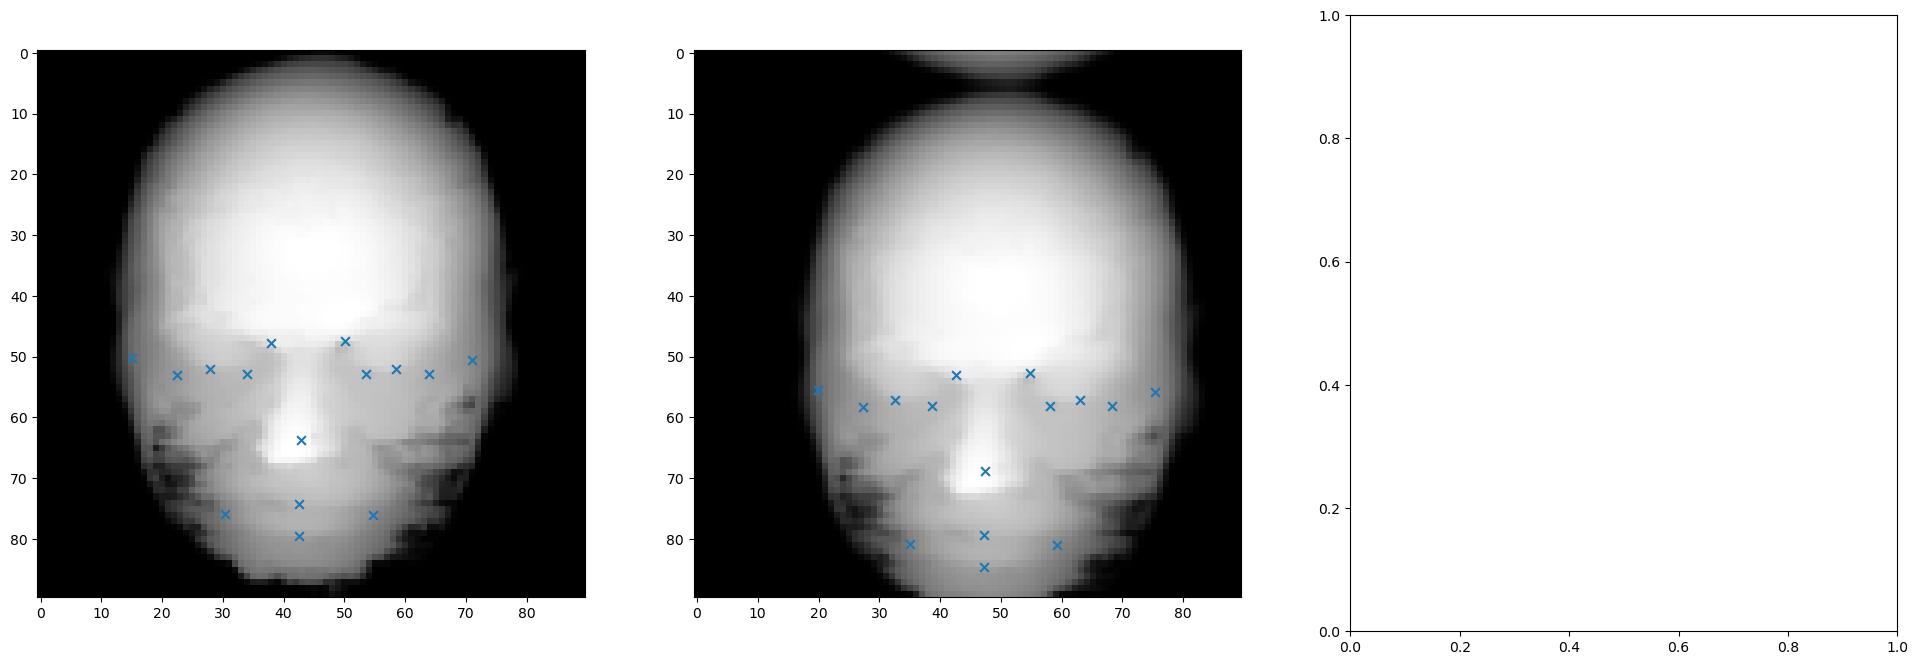

  0%|          | 0/1 [00:00<?, ?it/s]

Create logdir: ./test/face_kps_20211120T203131
Starting at epoch 0. lr=0.001
Checkpoint Path: ./test/face_kps_20211120T203131/face_kps_{epoch:04d}.pt
Epoch 1, lr=0.001000
Epoch 2, lr=0.001000
Epoch 3, lr=0.001000
Epoch 4, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5, lr=0.001000
Epoch 6, lr=0.001000
Epoch 7, lr=0.001000
Epoch 8, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9, lr=0.001000
Epoch 10, lr=0.001000
Epoch 11, lr=0.001000
Epoch 12, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13, lr=0.001000
Epoch 14, lr=0.001000
Epoch 15, lr=0.001000
Epoch 16, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17, lr=0.001000
Epoch 18, lr=0.001000
Epoch 19, lr=0.001000
Epoch 20, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21, lr=0.001000
Epoch 22, lr=0.001000
Epoch 23, lr=0.001000
Epoch 24, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25, lr=0.001000
Epoch 26, lr=0.001000
Epoch 27, lr=0.001000
Epoch 28, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29, lr=0.001000
Epoch 30, lr=0.001000
Epoch 31, lr=0.001000
Epoch 32, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33, lr=0.001000
Epoch 34, lr=0.001000
Epoch 35, lr=0.001000
Epoch 36, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37, lr=0.001000
Epoch 38, lr=0.001000
Epoch 39, lr=0.001000
Epoch 40, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41, lr=0.001000
Epoch 42, lr=0.001000
Epoch 43, lr=0.001000
Epoch 44, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45, lr=0.001000
Epoch 46, lr=0.001000
Epoch 47, lr=0.001000
Epoch 48, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49, lr=0.001000
Epoch 50, lr=0.001000
Epoch 51, lr=0.001000
Epoch 52, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53, lr=0.001000
Epoch 54, lr=0.001000
Epoch 55, lr=0.001000
Epoch 56, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57, lr=0.001000
Epoch 58, lr=0.001000
Epoch 59, lr=0.001000
Epoch 60, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61, lr=0.001000
Epoch 62, lr=0.001000
Epoch 63, lr=0.001000
Epoch 64, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65, lr=0.001000
Epoch 66, lr=0.001000
Epoch 67, lr=0.001000
Epoch 68, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69, lr=0.001000
Epoch 70, lr=0.001000
Epoch 71, lr=0.001000
Epoch 72, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73, lr=0.001000
Epoch 74, lr=0.001000
Epoch 75, lr=0.001000
Epoch 76, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77, lr=0.001000
Epoch 78, lr=0.001000
Epoch 79, lr=0.001000
Epoch 80, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81, lr=0.001000
Epoch 82, lr=0.001000
Epoch 83, lr=0.001000
Epoch 84, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85, lr=0.001000
Epoch 86, lr=0.001000
Epoch 87, lr=0.001000
Epoch 88, lr=0.001000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89, lr=0.000100
Epoch 90, lr=0.000100
Epoch 91, lr=0.000100
Epoch 92, lr=0.000100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93, lr=0.000100
Epoch 94, lr=0.000100
Epoch 95, lr=0.000100
Epoch 96, lr=0.000100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97, lr=0.000100
Epoch 98, lr=0.000100
Epoch 99, lr=0.000100
Epoch 100, lr=0.000100


100%|██████████| 1/1 [00:00<00:00, 98.25it/s, val_loss=2.8463, val_mae=1.3580]


In [ ]:
def toy_processor(img, kps, **kwargs):
    tf = A.Compose([
        A.ShiftScaleRotate(rotate_limit=0, scale_limit=0.1, p=1.0),
        # A.RandomBrightnessContrast(p=0.5),
        # A.GaussianBlur(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.Flip(p=0.5),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
    
    kps = np.array(tuple(zip(kps[::2], kps[1::2])))
    transformed = tf(image=img, keypoints=kps)
    img = transformed['image']
    kps = np.array(transformed['keypoints']).flatten(order='C')
    
    return img, kps


img = np.array(Image.open("aaa.png").convert('L')).astype('float32')
face = img[0:650, 200:550]
face = resize(img[0:650, 200:580], (90, 90))
kk = torch.as_tensor(clean_train_keypoints)[2]*0.9
kk[1::2] = kk[1::2]*0.7+30

toy_dataset = FaceDataset(np.stack([face] * 10), np.stack([kk] * 10), processor=toy_processor)
toy_dataset.display(1)

train_loader = torch.utils.data.DataLoader(
    toy_dataset, batch_size=train_config.BATCH_SIZE, shuffle=True,
)
val_loader = torch.utils.data.DataLoader(
    toy_dataset, batch_size=train_config.BATCH_SIZE, shuffle=False
)

model.train(train_loader, val_loader, epochs=100, config=train_config, 
            trainable_layers=".*", verbose=1)

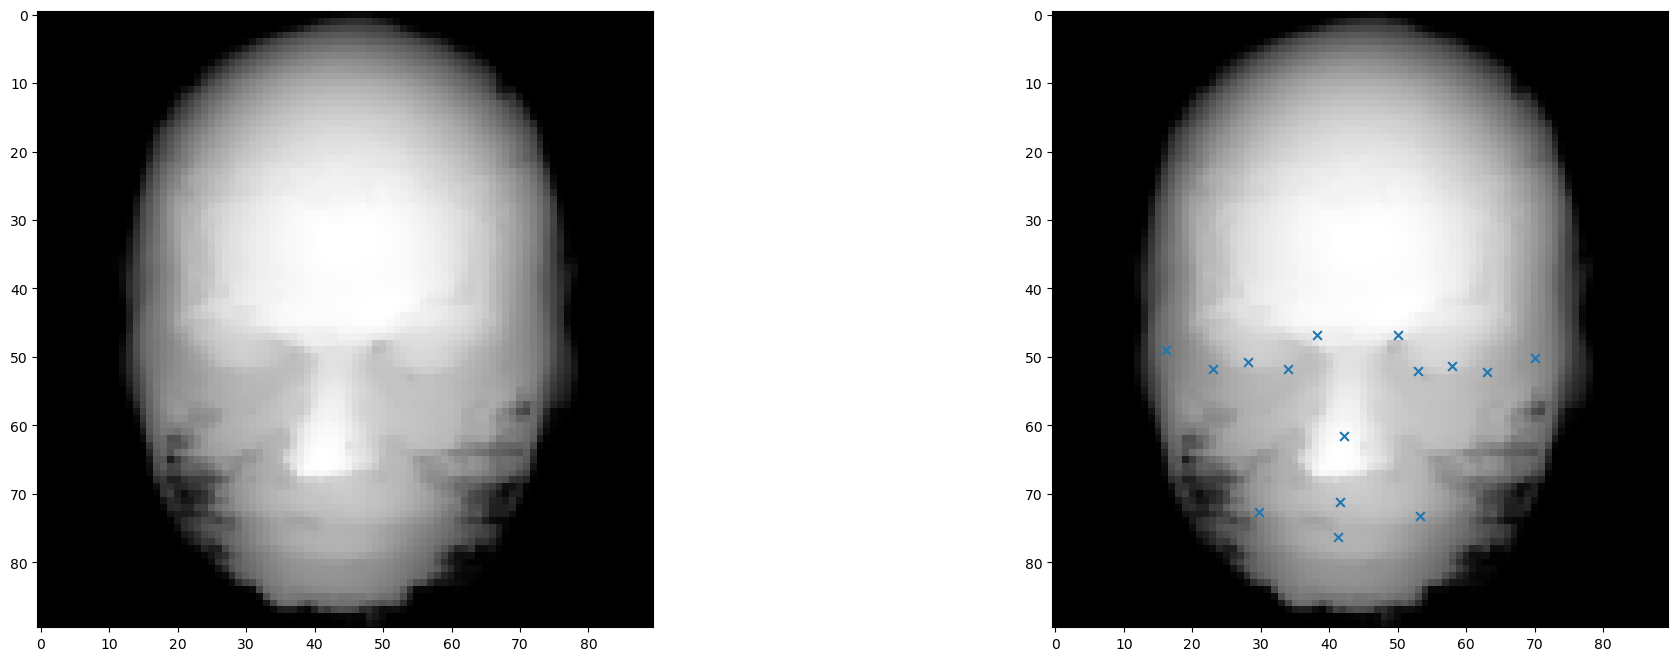

In [ ]:
model.model.eval()
r = model.model(ToTensor()(face).to(model.device)[None]).detach().cpu()[0]

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes[0].imshow(face, cmap='gray')
axes[1].imshow(face, cmap='gray')
axes[1].scatter(r.numpy()[::2], r.numpy()[1::2], marker='x', s=40)
plt.show()

In [ ]:
r

(10, 90, 90)